In [4]:
# imports

from functools import reduce
import itertools
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from barnacle import plot_factors_heatmap
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import tensorly as tl
from tensorly.cp_tensor import CPTensor
import tlviz
from tlviz.factor_tools import factor_match_score
from tlab.cp_tensor import load_cp_tensor
import xarray as xr
from barnacle.tensors import SparseCPTensor

# ignore chained assignment warning in pandas
pd.set_option('mode.chained_assignment', None)


In [5]:
# helpful functions
    
# function to select subset of indices in cp tensor
def subset_cp_tensor(cp_tensor, subset_indices):
    '''Selects subset of cp_tensor based on provided indices
    
    Parameters
    ----------
    cp_tensor : tensorly.CPTensor
        CPTensor object with (weights, factors).
    subset_indices : dict(int: index-like)
        Dictionary with mode as key and value an integer index of 
        the positions to be downselected from `cp_tensor`.
        Example: {1: [0, 1, 3, 4, 5, 8]}
        
    Returns
    -------
    subset_cp : tensorly.CPTensor
        Subset CPTensor.
    '''
    weights, factors = cp_tensor
    new_factors = factors.copy()
    for mode, index in subset_indices.items():
        new_factors[mode] = factors[mode][index]
    return(CPTensor((weights, new_factors)))


# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [6]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 100

div_hexes = ['#7222D3', neutral_color, '#FF780A']
div_cmap = get_continuous_cmap(div_hexes)


# collect and organize data

In [7]:
# import aligned models

# datapaths
datapath = Path('../../data/4-fitting/')
outdir = Path('../../figures/5-models/')

# import datasets
pro_ds = xr.open_dataset(datapath / '../5-models/pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / '../5-models/syn-aligned-models.nc')

pro_ds


<xarray.Dataset>
Dimensions:          (Bootstrap: 100, Replicate: 3, Component: 15,
                      Ortholog: 5023, Clade: 3, SampleName: 74)
Coordinates:
  * Bootstrap        (Bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * Replicate        (Replicate) object 'A' 'B' 'C'
  * Component        (Component) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * Ortholog         (Ortholog) int64 60000001 60000002 ... 60040287 60040292
  * Clade            (Clade) object 'HLI' 'HLII' 'LLI'
  * SampleName       (SampleName) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.NS...
Data variables:
    ComponentWeight  (Bootstrap, Replicate, Component) float64 ...
    GeneWeight       (Bootstrap, Replicate, Component, Ortholog) float64 ...
    TaxonWeight      (Bootstrap, Replicate, Component, Clade) float64 ...
    SampleWeight     (Bootstrap, Replicate, Component, SampleName) float64 ...
    Sample           (Bootstrap, Replicate, SampleName) object ...
    Annotation       (Ortholog) object ...
Attributes:
    Rank:               15
    Lambda:             15.0
    AlignRefBootstrap:  66
    AlignRefReplicate:  B

In [8]:
# data structures

# parameters
ref_boots = np.arange(100)
comp_boots= np.arange(10)
replicates = ['A', 'B', 'C']
ranks = {
    'pro': {
        'ref': pro_ds.Rank, 
        'comp': [1, 3, 6, 9, 12, 15]
    }, 
    'syn': {
        'ref': syn_ds.Rank, 
        'comp': [1, 3, 6, 9, 12, 15]
    }
}
lambdas = {
    'pro': {
        'ref': pro_ds.Lambda, 
        'comp': [1., 2., 4., 8., 16., 32., 64.]
    }, 
    'syn': {
        'ref': syn_ds.Lambda, 
        'comp': [1., 2., 4., 8., 16., 32., 64.]
    }
}

# set best representatives (based on analysis in analyses/5-models/compile-bootstraps.ipynb)
best_reps = {
    'pro': {
        'rank': pro_ds.Rank, 
        'lambda': pro_ds.Lambda, 
        'boot': pro_ds.AlignRefBootstrap, 
        'rep': pro_ds.AlignRefReplicate
    }, 
    'syn': {
        'rank': syn_ds.Rank, 
        'lambda': syn_ds.Lambda, 
        'boot': syn_ds.AlignRefBootstrap, 
        'rep': syn_ds.AlignRefReplicate
    }, 
}

# set up data structure to store sample name data
samplenames = {
    'pro' : {
        rep: [] for rep in replicates
    },
    'syn' : {
        rep: [] for rep in replicates
    }
}

# set up data structures to store cp tensors
cps = {
    'pro' : {
        rep: {} for rep in replicates
    },
    'syn' : {
        rep: {} for rep in replicates
    }
}
aligned_cps = {
    'pro' : {
        rep: {} for rep in replicates
    },
    'syn' : {
        rep: {} for rep in replicates
    }
}


In [9]:
# fetch samplename labels for each shuffled replicate set

# collect sample names of each bootstrap/replicate pair
for cyano in ['pro', 'syn']: 
    for rep in replicates:
        for boot in ref_boots:
            filepath = datapath / '{}/bootstrap{}/replicate{}/shuffled-replicate-{}.nc'.format(
                cyano, boot, rep, rep
            )
            ds = xr.open_dataset(filepath)
            samplenames[cyano][rep].append(ds.SampleName.data)

    # compile set of samplenames common to all bootstrap / replicate splits
    samplenames[cyano]['common'] = reduce(
        np.intersect1d, 
        itertools.chain.from_iterable([samplenames[cyano][r] for r in replicates])
    )

# check that common sample names match aligned reference set
pro_counts = pro_ds.SampleWeight.to_series().groupby('SampleName').count()
print(np.all(sorted(samplenames['pro']['common']) == sorted(pro_counts[pro_counts == pro_counts.max()].index)))
syn_counts = syn_ds.SampleWeight.to_series().groupby('SampleName').count()
print(np.all(sorted(samplenames['syn']['common']) == sorted(syn_counts[syn_counts == syn_counts.max()].index)))


True
True


In [10]:
# import all fitted models, and subset them to just the common samplenames

for cyano in ['pro', 'syn']:
    for rep in replicates:
        for rank in ranks[cyano]['comp']:
            # initialize dict of cp tensors for each rank
            cps[cyano][rep][rank] = {}
            aligned_cps[cyano][rep][rank] = {}
            # make list of lambdas
            lambda_set = set(lambdas[cyano]['comp'] + [lambdas[cyano]['ref']])
            for lamb in lambda_set:
                # initialize list of cp tensors for each lambda
                cps[cyano][rep][rank][lamb] = []
                aligned_cps[cyano][rep][rank][lamb] = []
                for boot in ref_boots:
                    if boot not in comp_boots and not (rank == ranks[cyano]['ref'] and lamb == lambdas[cyano]['ref']):
                        continue    # only pull in higher bootstrap models corresponding to reference model
                    # put together data path
                    path_cp = '{}/bootstrap{}/replicate{}/rank{}/lambda{}/fitted-model.h5'.format(
                        cyano, boot, rep, rank, lamb
                    )
                    # store normalized cp tensor to cps
                    cp = tl.cp_normalize(load_cp_tensor(datapath / path_cp))
                    cps[cyano][rep][rank][lamb].append(cp)
                    # pull out common samplenames and store in aligned_cps
                    idx = np.where(np.isin(samplenames[cyano][rep][boot], samplenames[cyano]['common']))[0]
                    aligned_cps[cyano][rep][rank][lamb].append(
                        subset_cp_tensor(cp, {2: idx})
                    )
            
aligned_cps['pro'][best_reps['pro']['rep']][best_reps['pro']['rank']][best_reps['pro']['lambda']][best_reps['pro']['boot']]


(weights, factors) : rank-15 CPTensor of shape (5023, 3, 41)

# compare aligned components

In [11]:
# collect aligned component comparison data

results = []
for cyano in ['pro', 'syn']:
    # pull out reference cp
    ref_rep = best_reps[cyano]['rep']
    ref_rank = best_reps[cyano]['rank']
    ref_lamb = best_reps[cyano]['lambda']
    ref_boot = best_reps[cyano]['boot']
    # sort reference cp factors in order of explained variance
    reference_cp = tlviz.factor_tools.permute_cp_tensor(
        aligned_cps[cyano][ref_rep][ref_rank][ref_lamb][ref_boot], 
        consider_weights=True
    ) 
    aligned_cps[cyano][ref_rep][ref_rank][ref_lamb][ref_boot] = reference_cp
    # separate out components
    ref_components = SparseCPTensor(reference_cp).get_components()
    # iterate through all cp tensors to be compared
    for comp_rep, comp_rank, comp_lamb, comp_boot in list(itertools.product(
            replicates, ranks[cyano]['comp'], lambdas[cyano]['comp'], ref_boots
        )):
        if comp_boot not in comp_boots and not (comp_rank == ranks[cyano]['ref'] and comp_lamb == lambdas[cyano]['ref']):
            continue    # only look at bootstraps beyond comparison bootstraps if they match reference params
        elif ref_rep == comp_rep and ref_rank == comp_rank and ref_lamb == comp_lamb and ref_boot == comp_boot:
            continue    # no point in comparing to self
        # re-align comparison cp to the reference cp
        comparison_cp = tlviz.factor_tools.permute_cp_tensor(
            aligned_cps[cyano][comp_rep][comp_rank][comp_lamb][comp_boot], 
            reference_cp_tensor=reference_cp, 
            consider_weights=False, 
            allow_smaller_rank=True
        )
        aligned_cps[cyano][comp_rep][comp_rank][comp_lamb][comp_boot] = comparison_cp
        # compare each aligned component
        for i, comp_component in enumerate(SparseCPTensor(comparison_cp).get_components()):
            # skip the None-type components included for aligning smaller cp tensors
            if np.all(np.isnan(comp_component.factors[0])):
                continue
            # compare components
            fms = factor_match_score(
                comp_component, 
                ref_components[i], 
                consider_weights=False,
            )
            # save results
            results.append({
                'genus': cyano, 
                'reference_bootstrap': ref_boot, 
                'reference_replicate': ref_rep, 
                'reference_rank': ref_rank, 
                'reference_lambda': ref_lamb, 
                'reference_component': i, 
                'comparison_bootstrap': comp_boot, 
                'comparison_replicate': comp_rep, 
                'comparison_rank': comp_rank, 
                'comparison_lambda': comp_lamb, 
                'comparison_component': i, 
                'fms': fms 
            })
            
component_df = pd.DataFrame(results)
component_df


,genus,reference_bootstrap,reference_replicate,reference_rank,reference_lambda,reference_component,comparison_bootstrap,comparison_replicate,comparison_rank,comparison_lambda,comparison_component,fms
0,pro,66,B,15,15.0,1,0,A,1,1.0,1,0.507840
1,pro,66,B,15,15.0,11,1,A,1,1.0,11,0.471818
2,pro,66,B,15,15.0,0,2,A,1,1.0,0,0.435995
3,pro,66,B,15,15.0,6,3,A,1,1.0,6,0.011072
4,pro,66,B,15,15.0,11,4,A,1,1.0,11,0.625610
...,...,...,...,...,...,...,...,...,...,...,...,...
19315,syn,26,C,15,10.0,10,9,C,15,64.0,10,0.000000
19316,syn,26,C,15,10.0,11,9,C,15,64.0,11,0.534117
19317,syn,26,C,15,10.0,12,9,C,15,64.0,12,0.000000
19318,syn,26,C,15,10.0,13,9,C,15,64.0,13,0.320994


# plot component robustness

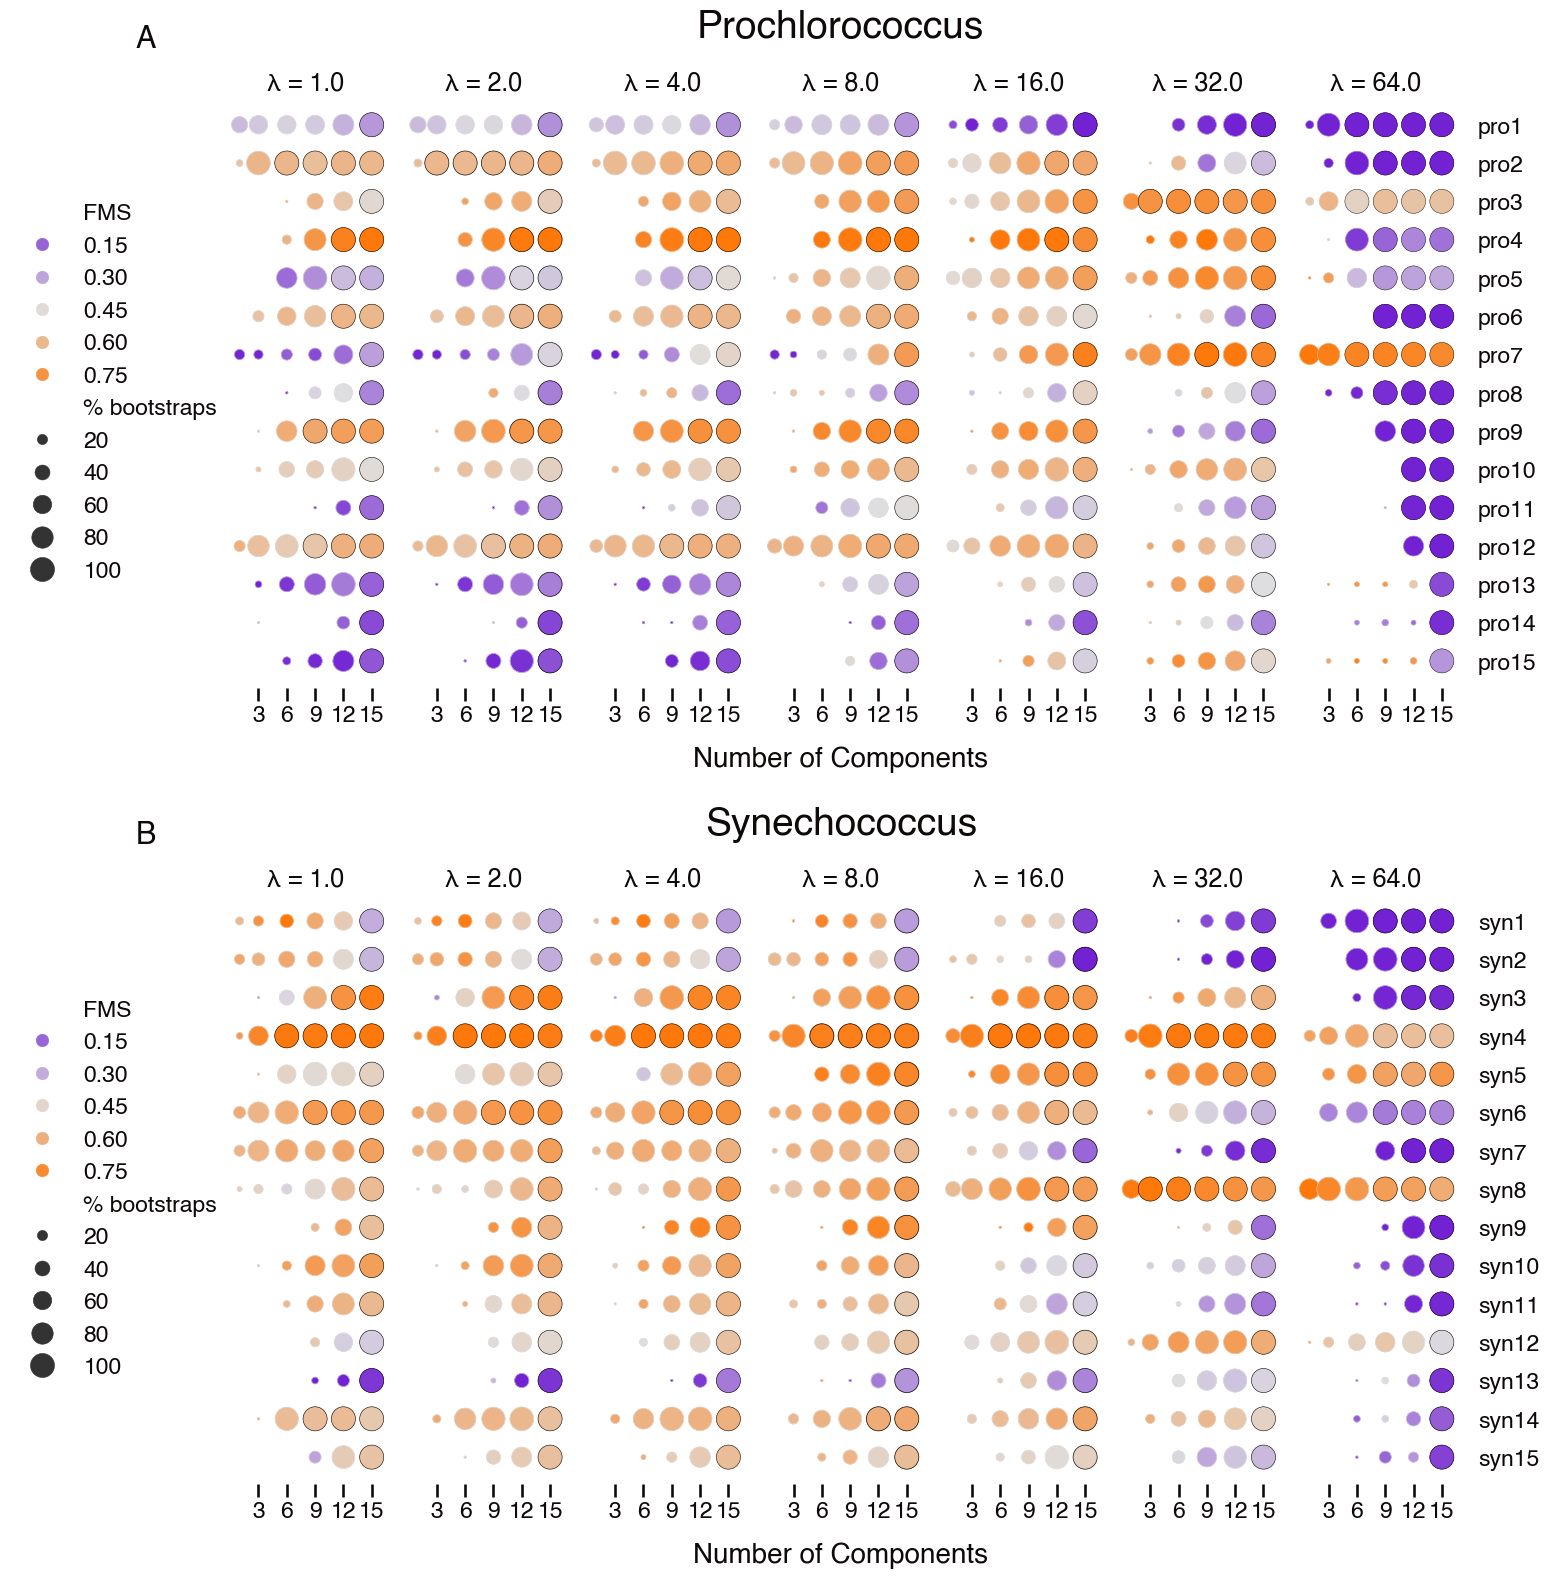

In [16]:
# component robustness to sparsity

# make multiple plots
fig, axes = plt.subplots(
    2, len(lambdas[cyano]['comp']), figsize=(16, 18), sharey='row', gridspec_kw={'wspace': 0.05, 'hspace': 0.35}
)
marker_palette = {True: line_color, False: neutral_color}

# iterate through cyanobacteria
for row, cyano in enumerate(['pro', 'syn']):
    
    # set up component robustness dataframe
    df = component_df[component_df['genus'] == cyano]
    df = df.groupby(['comparison_rank', 'comparison_lambda', 'reference_component']).agg(
        FMS = ('fms', 'mean'), 
        bootstrap_count = ('fms', 'count')
    ).reset_index()
    # calculate bootstrap percentage
    df['total_bootstraps'] = len(comp_boots) * 3
    df.loc[
        (df['comparison_rank'] == ranks[cyano]['ref']) & (df['comparison_lambda'] == lambdas[cyano]['ref']), 
        'total_bootstraps'
    ] = (len(ref_boots) * 3) - 1
    df['% bootstraps'] = df['bootstrap_count'] / df['total_bootstraps'] * 100
    df['all bootstraps'] = df['% bootstraps'] == 100
    # reverse component index order
    n_components = df['reference_component'].max() + 1
    df['component_index'] = n_components - df['reference_component']
    
    # iterate through the different sparsity coefficient values
    for i, lamb in enumerate(lambdas[cyano]['comp']):
        plot_df = df[df['comparison_lambda'] == lamb]
        sns.scatterplot(
            x='comparison_rank', 
            y='component_index', 
            hue='FMS', 
            size='% bootstraps', 
            sizes=(3, 300), 
            edgecolor=None, 
            palette=div_cmap, 
            data=plot_df, 
            legend=(not i),
            ax=axes[row][i]
        ); 
        # hackey solution to fix legend freaking out over different edge colors
        sns.scatterplot(
            x='comparison_rank', 
            y='component_index', 
            hue='FMS', 
            size='% bootstraps', 
            sizes=(3, 300), 
            edgecolor=plot_df['all bootstraps'].map(marker_palette), 
            palette=div_cmap, 
            data=plot_df, 
            legend=False,
            ax=axes[row][i]
        );
        axes[row][i].set(xlabel=None, xlim=(-1, 17), xticks=[3, 6, 9, 12, 15], 
                         ylabel=None, title='λ = {}'.format(lamb))
        if i == 0:
            axes[row][i].tick_params(left=False, right=False, labelleft=False, labelright=False)
            # make legend
            axes[row][i].legend(loc='center right', alignment='right', bbox_to_anchor=(0.1, 0.5));
        elif i == len(lambdas[cyano]['comp']) - 1:
            # set cluster labels
            axes[row][-1].tick_params(left=False, right=False, labelleft=False, labelright=True)
            axes[row][-1].set_yticks(n_components - np.arange(n_components), 
                                     [f'{cyano}{i+1}' for i in np.arange(n_components)]);
            # for tick in axes[row][-1].get_yticklabels():
            #     tick.set_color({'pro': sns.color_palette()[2], 'syn': sns.color_palette()[3]}[cyano])
        else:
            axes[row][i].tick_params(left=False, right=False, labelleft=False, labelright=False)
            
    # add annotations
    axes[row][0].annotate(
        {0: 'A', 1: 'B'}[row], xy=(-0.5, 1.1), xycoords='axes fraction', va='center', ha='left', 
        weight='bold', fontsize=22, annotation_clip=False
    )
    axes[row][3].annotate(
        {0: 'Prochlorococcus', 1: 'Synechococcus'}[row], xy=(0.5, 1.12), xycoords='axes fraction', 
        va='center', ha='center', weight='bold', style='italic', fontsize=28, annotation_clip=False
    )
    axes[row][3].annotate(
        'Number of Components', xy=(0.5, -0.12), xycoords='axes fraction', 
        va='center', ha='center', fontsize=20, annotation_clip=False
    )

fig.savefig(outdir / 'component-robustness-sparsity.png', bbox_inches='tight')


# Look at cross-validated component FMS values across lambda parameterizations

In [17]:
# calculated cross-validated component FMS score for aligned CP tensors

# begin calculation
results = []
for cyano in ['pro', 'syn']:
    rank = ranks[cyano]['ref']
    # iterate through lambda levels
    for lamb in lambdas[cyano]['comp']:
        # iterate through bootstraps:
        for boot in comp_boots:
            # iterate through replicate pairs
            for ref_rep, comp_rep in [('A', 'B'), ('B', 'C'), ('C', 'A')]:
                reference_cp = aligned_cps[cyano][ref_rep][rank][lamb][boot]
                comparison_cp = aligned_cps[cyano][comp_rep][rank][lamb][boot]
                # pull out comparison components
                comp_components = SparseCPTensor(comparison_cp).get_components()
                # iterate through reference components
                for i, ref_component in enumerate(SparseCPTensor(reference_cp).get_components()):
                    if np.all(np.isnan(ref_component.factors[0])) or np.all(np.isnan(comp_components[i].factors[0])):
                        fms = np.nan
                        cluster_size = 0
                        neg_weights = 0
                        poz_weights = 0
                    else:
                        # compare components
                        fms = factor_match_score(
                            comp_components[i], 
                            ref_component, 
                            consider_weights=False,
                        )
                        # calculate genes per cluster
                        cluster_size = (ref_component.factors[0] != 0).sum()
                        neg_weights = (ref_component.factors[0] < 0).sum()
                        poz_weights = (ref_component.factors[0] > 0).sum()
                        # save results
                        results.append({
                            'genus': cyano, 
                            'bootstrap': boot, 
                            'rank': rank, 
                            'lambda': lamb, 
                            'component': i, 
                            'reference_replicate': ref_rep, 
                            'comparison_replicate': comp_rep, 
                            'ref_gene_cluster_size': cluster_size, 
                            'ref_neg_weights': neg_weights, 
                            'ref_poz_weights': poz_weights, 
                            'fms': fms
                        })
            
cv_comp_fms_df = pd.DataFrame(results)
cv_comp_fms_df


,genus,bootstrap,rank,lambda,component,reference_replicate,comparison_replicate,ref_gene_cluster_size,ref_neg_weights,ref_poz_weights,fms
0,pro,0,15,1.0,0,A,B,1456,222,1234,0.025628
1,pro,0,15,1.0,1,A,B,928,337,591,0.471001
2,pro,0,15,1.0,2,A,B,447,186,261,0.894573
3,pro,0,15,1.0,3,A,B,749,269,480,0.866428
4,pro,0,15,1.0,4,A,B,1192,358,834,0.086288
...,...,...,...,...,...,...,...,...,...,...,...
6295,syn,9,15,64.0,10,C,A,0,0,0,0.000000
6296,syn,9,15,64.0,11,C,A,2,0,2,0.533603
6297,syn,9,15,64.0,12,C,A,0,0,0,0.000000
6298,syn,9,15,64.0,13,C,A,1,0,1,0.000000


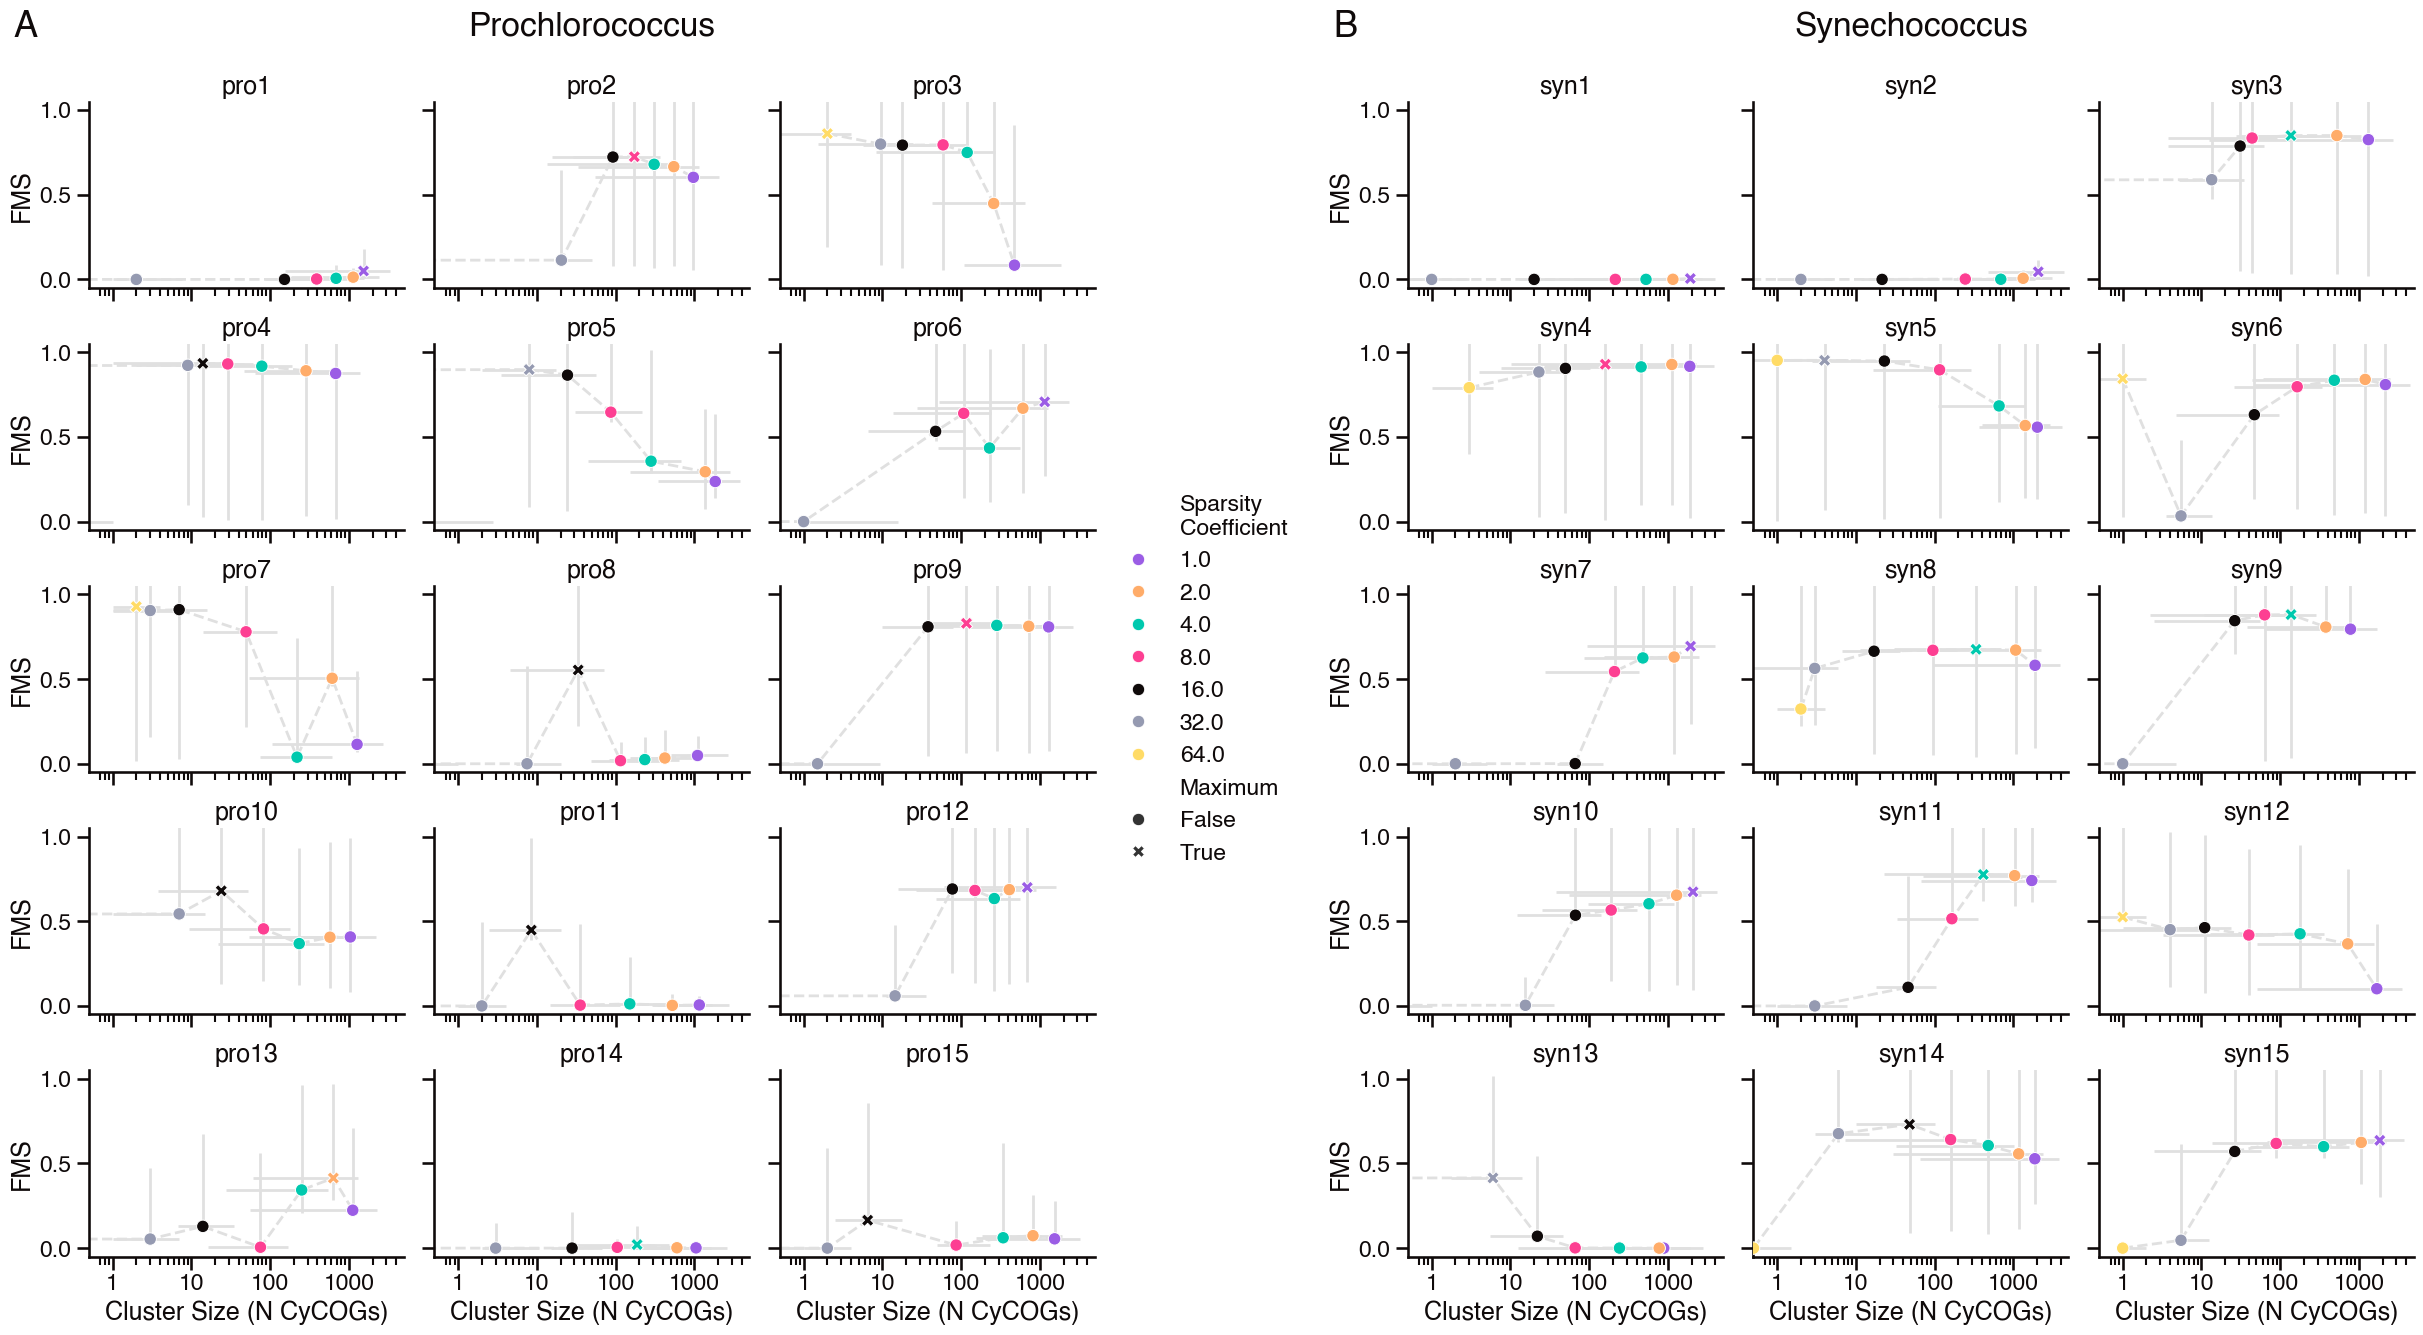

In [43]:
# plot each component FMS profile for Prochlorococcus

rows = 5
cols = 7
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'center', 'fontsize': 22, 'annotation_clip': False
}

# set up lambda colormap
cmap = dict(zip(lambdas[genus]['comp'], accent_colors))

# set up figure
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
fig, axes = plt.subplots(
    rows, cols, figsize=(30, 15), sharex=False, sharey=False, 
    width_ratios=(1, 1, 1, .8, 1, 1, 1), gridspec_kw={'hspace': 0.3, 'wspace': 0.1}
)

for i, genus in enumerate(['pro', 'syn']):
    # plot each component
    for component in np.arange(15):
        row = component // 3
        col = component % 3 + (i * 4)
        axis = axes[row][col]
        plot_df = cv_comp_fms_df[cv_comp_fms_df['genus'] == genus]
        plot_df = plot_df[plot_df['component'] == component]
        plot_df = pd.merge(
            left=plot_df.groupby('lambda').fms.quantile([0.25, 0.5, 0.75]).reset_index().pivot(
                columns='level_1', index='lambda', values='fms').rename(
                columns={0.25: 'fms_q1', 0.5: 'fms', 0.75: 'fms_q3'}).reset_index(), 
            right=plot_df.groupby('lambda').ref_gene_cluster_size.quantile([0.25, 0.5, 0.75]).reset_index().pivot(
                columns='level_1', index='lambda', values='ref_gene_cluster_size').rename(
                columns={0.25: 'size_q1', 0.5: 'cluster_size', 0.75: 'size_q3'}).reset_index(), 
            on='lambda'
        )
        plot_df['Maximum'] = (plot_df['fms'] == plot_df['fms'].max())
        plot_df['Sparsity\nCoefficient'] = ['{}'.format(l) for l in plot_df['lambda']]
        sns.lineplot(
            data=plot_df, 
            x='cluster_size', 
            y='fms', 
            errorbar=None, 
            color=neutral_color, 
            linestyle='--', 
            ax=axis, 
            legend=False
        )
        sns.scatterplot(
            data=plot_df, 
            x='cluster_size', 
            y='fms', 
            hue='Sparsity\nCoefficient', 
            style='Maximum', 
            zorder=3, 
            ax=axis, 
            legend=(row == col == 2)
        )
        # set legend location
        if (row == col == 2):
            axis.legend(loc='center left', bbox_to_anchor=[1, 0.5])
        # add errorbars
        axis.errorbar(
            x=plot_df['cluster_size'], 
            y=plot_df['fms'], 
            xerr=plot_df[['size_q1', 'size_q3']].T, 
            yerr=plot_df[['fms_q1', 'fms_q3']].T, 
            fmt='none', 
            ecolor=neutral_color
        )
        # set labels and such
        if component == 0:
            axis.annotate({'pro': 'A', 'syn': 'B'}[genus], xy=(-0.2, 1.4), va='center', ha='center', fontsize=26, 
                          annotation_clip=False, xycoords='axes fraction')
        elif component == 1: 
            axis.annotate({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus], xy=(0.5, 1.4), 
                          va='center', ha='center', fontsize=24, annotation_clip=False, xycoords='axes fraction')
        if row == (rows - 1):
            xlabel = 'Cluster Size (N CyCOGs)'
        else:
            xlabel = ''
        if col == 0 or col == 4:
            ylabel = 'FMS'
        else:
            ylabel = ''
        axis.set(
            xlim=[0.5, 5000], ylim=[-0.05, 1.05], xscale='log', xlabel=xlabel, ylabel=ylabel, 
            title='{}{}'.format(genus, component+1)
        )
        axis.set_xticks([1, 10, 100, 1000])
        axis.set_xticks([.7, .8, .9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 
                         200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000], minor=True)
        formatter = mpl.ticker.ScalarFormatter()
        formatter.set_scientific(False)
        axis.xaxis.set_major_formatter(formatter)
        axis.tick_params(labelleft=(col==0 or col==4), labelbottom=(row==(rows - 1)))

# remove center axes
for i in range(rows):
    fig.delaxes(axes[i][3])

# save figure
fig.savefig(outdir / 'cluster_fms_v_size.png'.format(genus), bbox_inches='tight')
    